# Pattern Enumeration
[![pattern_enumeration.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_enumeration.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_enumeration.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_enumeration.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_enumeration.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_enumeration.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/fdabrandao/examples/pattern_enumeration.ipynb)](https://colab.ampl.com)

Description: Pattern enumeration example with amplpy

Tags: amplpy, example

Notebook author: Filipe Brandão <<fdabrandao@gmail.com>>

Model author: N/A

References: N/A

In [1]:
# Install dependencies
%pip install -q amplpy==0.15.0b2 amplpy matplotlib numpy

In [2]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Basic pattern-cutting model

In [3]:
%%ampl_eval
param nPatterns integer > 0;
set PATTERNS = 1..nPatterns; # patterns
set WIDTHS; # finished widths
param order {WIDTHS} >= 0; # rolls of width j ordered
param overrun; # permitted overrun on any width
param rolls {WIDTHS,PATTERNS} >= 0 default 0; # rolls of width i in pattern j

var Cut {PATTERNS} integer >= 0; # raw rolls to cut in each pattern

minimize TotalRawRolls: sum {p in PATTERNS} Cut[p];

subject to FinishedRollLimits {w in WIDTHS}:
  order[w] <= sum {p in PATTERNS} rolls[w,p] * Cut[p] <= order[w] + overrun;

## Enumeration routine

In [4]:
from math import floor


def patternEnum(roll_width, widths, prefix=[]):
    max_rep = int(floor(roll_width / widths[0]))
    if len(widths) == 1:
        patmat = [prefix + [max_rep]]
    else:
        patmat = []
        for n in reversed(range(max_rep + 1)):
            patmat += patternEnum(roll_width - n * widths[0], widths[1:], prefix + [n])
    return patmat

## Plotting routine

In [5]:
def cuttingPlot(roll_width, widths, solution):
    import numpy as np
    import matplotlib.pyplot as plt

    ind = np.arange(len(solution))
    acc = [0] * len(solution)
    for p, (patt, rep) in enumerate(solution):
        for i in range(len(widths)):
            for j in range(patt[i]):
                vec = [0] * len(solution)
                vec[p] = widths[i]
                plt.bar(ind, vec, width=0.35, bottom=acc)
                acc[p] += widths[i]
    plt.title("Solution")
    plt.xticks(ind, tuple("x {:}".format(rep) for patt, rep in solution))
    plt.yticks(np.arange(0, roll_width, 10))
    plt.show()

## Set & generate data

In [6]:
roll_width = 64.5
overrun = 6
orders = {6.77: 10, 7.56: 40, 17.46: 33, 18.76: 10}
widths = list(sorted(orders.keys(), reverse=True))
patmat = patternEnum(roll_width, widths)

## Send data to AMPL (Java/C++ style)

In [7]:
# Send scalar values
ampl.get_parameter("overrun").set(overrun)
ampl.get_parameter("nPatterns").set(len(patmat))
# Send order vector
ampl.get_set("WIDTHS").set_values(widths)
ampl.get_parameter("order").set_values(orders)
# Send pattern matrix
ampl.get_parameter("rolls").set_values(
    {
        (widths[i], 1 + p): patmat[p][i]
        for i in range(len(widths))
        for p in range(len(patmat))
    }
)

## Send data to AMPL (alternative style)

In [8]:
# Send scalar values
ampl.param["overrun"] = overrun
ampl.param["nPatterns"] = len(patmat)
# Send order vector
ampl.set["WIDTHS"] = widths
ampl.param["order"] = orders
# Send pattern matrixc
ampl.param["rolls"] = {
    (widths[i], 1 + p): patmat[p][i]
    for i in range(len(widths))
    for p in range(len(patmat))
}

## Solve and report

Gurobi 9.5.0: optimal solution; objective 18
6 simplex iterations
1 branch-and-cut nodes


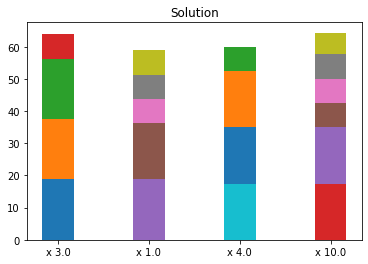

In [9]:
# Solve
ampl.solve(solver="gurobi")
assert ampl.solve_result == "solved"

# Retrieve solution
cutvec = ampl.var["Cut"].to_list(skip_index=True)

# Display solution
solution = [(patmat[p], cutvec[p]) for p in range(len(patmat)) if cutvec[p] > 0]
cuttingPlot(roll_width, widths, solution)